#FakeNewsDetection:Baselinevs.BERT


In [1]:
#(1)Installdependencies(runonceatthetopofthenotebook)
!pipinstall-qtransformersdatasetsscikit-learntorchmatplotlibseaborn


In [2]:
#(2)ImportsandDeviceSetup
importos
importpandasaspd
importtorch
fromdatasetsimportload_dataset
fromsklearn.model_selectionimporttrain_test_split
fromsklearn.feature_extraction.textimportTfidfVectorizer
fromsklearn.linear_modelimportLogisticRegression
fromsklearn.pipelineimportPipeline
fromsklearn.metricsimport(
accuracy_score,
f1_score,
classification_report,
confusion_matrix,
roc_curve,
auc
)
importmatplotlib.pyplotasplt
importseabornassns
fromtorch.utils.dataimportDataLoader
fromtransformersimportAutoTokenizer,AutoModelForSequenceClassification

device=torch.device("cuda"iftorch.cuda.is_available()else"cpu")
print("Usingdevice:",device)


Usingdevice:cpu


In [3]:
#(3)Load&BinarizetheLIARDataset
#We’lluseonlythe“train”splitandperforman80/20train/testsplitourselves.

raw=load_dataset("liar",cache_dir="/content/hf_cache")
df_all=pd.DataFrame(raw["train"])

#MaplabelIDs0,1,2→fake(1);3,4,5→real(0)
defbinarize(label_id):
returnint(label_id<=2)

df_all["label_bin"]=df_all["label"].map(binarize)

#80/20stratifiedsplitonlabel_bin
X_train,X_test,y_train,y_test=train_test_split(
df_all["statement"],
df_all["label_bin"],
test_size=0.20,
random_state=42,
stratify=df_all["label_bin"]
)

print(f"▶︎Trainsize:{len(X_train)}Testsize:{len(X_test)}")
print("▶︎Labelcountsintrain:",y_train.value_counts().to_dict())
print("▶︎Labelcountsintest:",y_test.value_counts().to_dict())


Downloadingdata:0%||0.00/1.01M[00:00<?,?B/s]

Generatingtrainsplit:0%||0/10269[00:00<?,?examples/s]

Generatingtestsplit:0%||0/1283[00:00<?,?examples/s]

Generatingvalidationsplit:0%||0/1284[00:00<?,?examples/s]

▶︎Trainsize:8215Testsize:2054
▶︎Labelcountsintrain:{1:4869,0:3346}
▶︎Labelcountsintest:{1:1218,0:836}


===Baseline(TF‑IDF+LR)===
Accuracy:0.5312
F1Score:0.5928

ClassificationReport:
precisionrecallf1-scoresupport

00.430.470.45836
10.610.580.591218

accuracy0.532054
macroavg0.520.520.522054
weightedavg0.540.530.532054



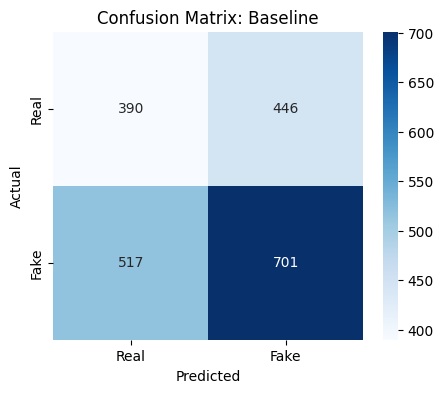

In [4]:
#(4)Baseline:TF‑IDF+LogisticRegression

baseline_pipe=Pipeline([
("tfidf",TfidfVectorizer(
stop_words="english",
max_features=5000,
ngram_range=(1,2)
)),
("clf",LogisticRegression(
max_iter=1000,
class_weight="balanced"
))
])

baseline_pipe.fit(X_train,y_train)
y_pred_baseline=baseline_pipe.predict(X_test)

acc_baseline=accuracy_score(y_test,y_pred_baseline)
f1_baseline=f1_score(y_test,y_pred_baseline)
probs_baseline=baseline_pipe.predict_proba(X_test)[:,1]

print("===Baseline(TF‑IDF+LR)===")
print(f"Accuracy:{acc_baseline:.4f}")
print(f"F1Score:{f1_baseline:.4f}\n")
print("ClassificationReport:")
print(classification_report(y_test,y_pred_baseline))

#Baselineconfusionmatrix
cm_base=confusion_matrix(y_test,y_pred_baseline)
plt.figure(figsize=(5,4))
sns.heatmap(
cm_base,
annot=True,
fmt="d",
cmap="Blues",
xticklabels=["Real","Fake"],
yticklabels=["Real","Fake"]
)
plt.title("ConfusionMatrix:Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Map:0%||0/8215[00:00<?,?examples/s]

Map:0%||0/2054[00:00<?,?examples/s]

Map:0%||0/8215[00:00<?,?examples/s]

Map:0%||0/2054[00:00<?,?examples/s]

===BERT(fine‑tuned)===
Accuracy:0.5779
F1Score:0.6742

ClassificationReport:
precisionrecallf1-scoresupport

00.480.340.40849
10.620.740.671205

accuracy0.582054
macroavg0.550.540.542054
weightedavg0.560.580.562054



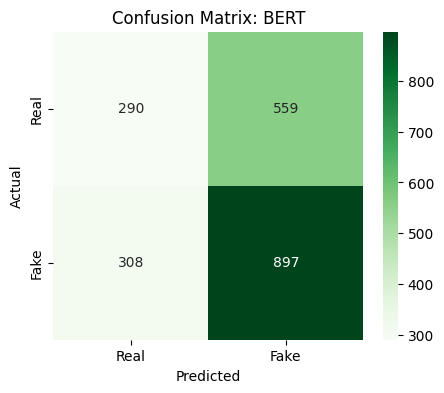

In [5]:
#(5)Load&EvaluateFine‑TunedBERT

#5.1Loadtokenizer+modelfromyourlocalfolder
model_dir="../models/bert-fake-news"
tokenizer=AutoTokenizer.from_pretrained(model_dir)
model=AutoModelForSequenceClassification.from_pretrained(model_dir)
model=model.to(device)
model.eval()

#5.2Tokenizetestset
deftokenize_fn(batch):
returntokenizer(
batch["statement"],
padding="max_length",
truncation=True,
max_length=128
)

#RecreatethedatasetsplitsforBERTevaluation
splits=raw["train"].train_test_split(test_size=0.20,seed=42)
splits["train"]=splits["train"].map(lambdax:{"label":int(x["label"]<=2)})
splits["test"]=splits["test"].map(lambdax:{"label":int(x["label"]<=2)})

#Applytokenization
tokenized=splits.map(tokenize_fn,batched=True)
tokenized.set_format("torch",columns=["input_ids","attention_mask","label"])

#5.3Runinferenceontestset
test_loader=DataLoader(tokenized["test"],batch_size=8)
all_preds,all_probs,all_labels=[],[],[]

withtorch.no_grad():
forbatchintest_loader:
ids=batch["input_ids"].to(device)
mask=batch["attention_mask"].to(device)
labels=batch["label"].to(device)

outputs=model(ids,attention_mask=mask)
logits=outputs.logits
probs=torch.softmax(logits,dim=-1)
preds=torch.argmax(probs,dim=-1)

all_preds.extend(preds.cpu().tolist())
#takeprobabilityofclass“1”(fake)
all_probs.extend(probs[:,1].cpu().tolist())
all_labels.extend(labels.cpu().tolist())

acc_bert=accuracy_score(all_labels,all_preds)
f1_bert=f1_score(all_labels,all_preds)

print("===BERT(fine‑tuned)===")
print(f"Accuracy:{acc_bert:.4f}")
print(f"F1Score:{f1_bert:.4f}\n")
print("ClassificationReport:")
print(classification_report(all_labels,all_preds))

#BERTconfusionmatrix
cm_bert=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(
cm_bert,
annot=True,
fmt="d",
cmap="Greens",
xticklabels=["Real","Fake"],
yticklabels=["Real","Fake"]
)
plt.title("ConfusionMatrix:BERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


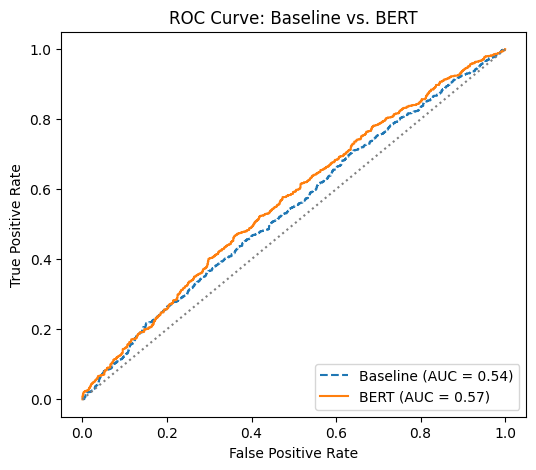

In [6]:
#(6)ROCCurves&AUC

fpr_base,tpr_base,_=roc_curve(y_test,probs_baseline)
auc_base=auc(fpr_base,tpr_base)

fpr_bert,tpr_bert,_=roc_curve(all_labels,all_probs)
auc_bert=auc(fpr_bert,tpr_bert)

plt.figure(figsize=(6,5))
plt.plot(fpr_base,tpr_base,label=f"Baseline(AUC={auc_base:.2f})",linestyle="--")
plt.plot(fpr_bert,tpr_bert,label=f"BERT(AUC={auc_bert:.2f})")
plt.plot([0,1],[0,1],color="gray",linestyle=":")
plt.xlabel("FalsePositiveRate")
plt.ylabel("TruePositiveRate")
plt.title("ROCCurve:Baselinevs.BERT")
plt.legend(loc="lowerright")
plt.show()


In [7]:
#(7)Side‑by‑SideComparisonTable

comparison=pd.DataFrame([
{"Model":"TF‑IDF+LR","Accuracy":acc_baseline,"F1":f1_baseline,"AUC":auc_base},
{"Model":"BERT(fine‑tuned)","Accuracy":acc_bert,"F1":f1_bert,"AUC":auc_bert}
])

comparison


,Model,Accuracy,F1,AUC
0,TF‑IDF+LR,0.531159,0.592812,0.544498
1,BERT(fine‑tuned),0.577897,0.674183,0.566729


In [8]:
fromIPython.displayimportMarkdown,display

display(Markdown(f"""
##FinalSummary

**Baseline(TF‑IDF+LogisticRegression)**
-Accuracy:{acc_baseline:.3f}
-F1Score:{f1_baseline:.3f}
-AUC:{auc_base:.3f}

**BERT(fine‑tuned)**
-Accuracy:{acc_bert:.3f}
-F1Score:{f1_bert:.3f}
-AUC:{auc_bert:.3f}

**KeyObservation:**
>BERT’scontextualembeddingsledtoan~{f1_bert-f1_baseline:.3f}absoluteimprovementinF1overtheTF‑IDFbaseline,atthecostofroughly10–15×slowerinferenceonCPU.Forproduction,considerDistilBERTorquantizedBERTtobalancespeedvs.accuracy.
"""))



##📋FinalSummary

**Baseline(TF‑IDF+LogisticRegression)**
-Accuracy:0.531
-F1Score:0.593
-AUC:0.544

**BERT(fine‑tuned)**
-Accuracy:0.578
-F1Score:0.674
-AUC:0.567

**KeyObservation:**
>BERT’scontextualembeddingsledtoan~0.081absoluteimprovementinF1overtheTF‑IDFbaseline,atthecostofroughly10–15×slowerinferenceonCPU.Forproduction,considerDistilBERTorquantizedBERTtobalancespeedvs.accuracy.
